<a href="https://colab.research.google.com/github/jinu9688/VI_lecture_homework-1/blob/main/road_lane_line_detection_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##20163331 전진우 차량지능기초 과제1 2)

이 프로젝트의 목표는 학습한 도구를 사용하여 도로의 차선을 식별하는 것이다. 각각의 훈련 데이터에 대한 도구를 설정하고 결과를 비디오로 보여준다. line_segment를 식별하기 위해서 평균화하거나 추정하여 차선 전체를 그려야 한다.
사용하는 도구로는 color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection을 사용한다. 이미지의 line_segment를 식별하여 감지한 후 평균/축소하여 표시할 이미지에 그릴 수 있다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#구글 드라이브와 코렙을 연결하는 코드

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


이미지를 불러오기

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
#이미지와 사진을 가져오는 모듈과 패키지를 가져옴

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


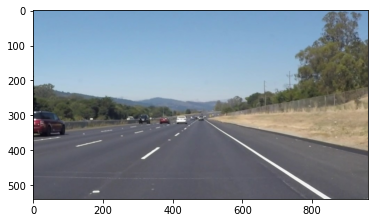

In [ ]:
image = mpimg.imread('/content/drive/MyDrive/Colab_Notebooks/road_lane_line_detection/test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  
#이미지를 파일이 위치하는 경로를 따라 읽은 후에 이미지의 type과 shape을 보여준다

필요한 함수 설정

In [ ]:
import math
#아래부터는 함수를 설정한다.

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#grayscale함수는 이미지를 grayscale로 변환한다. 

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)
#canny함수는 canny tranform을 정의한다.

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
#gaussian_blur함수는 Gauss noice kernal을 적용한다.

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   

    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
          
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
#region_of_interest함수는 먼저 빈 mask를 정의한다.
#이후 입력 이미지에 따라 마스클르 채울 1 또는 3 channel color를 표시한다
#'필링'에 의해 정의된 poligon내부에 pixel를 담는다
#poligon에 의해 정의된 영상의 영역만 유지학 나머지 부분은 검은색으로 표시한다.
#마스크 pixel이 0이 아닌 경우에만 영상을 표시한다.


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
#draw_lines함수는 시작점으로 사용하는 경우에 사용할 수 있다. 전체 지도를 작성하기 위해서 탐지한 line segment을 평균화/축소한다.
#line segment는 기울기를 이용하여 right/left 중 어느 segment가 왼쪽의 일부인지 결정해 다음 위치의 평균을 구한다.

    draw_right = True
    draw_left = True
    
#아래는 모든 선의 기울기를 찾는다
#기울기의 절댓값이 경사 임계값(slope_threshold)보다 큰 선만을 확인한다.
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0] 
#경사 계산
        if x2 - x1 == 0.:  
            slope = 999.  
        else:
            slope = (y2 - y1) / (x2 - x1)
        
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    
#우측 차선 및 좌측 차선 표시로 선을 right과 left 라인으로 분할
#이 때, 우측/좌측 차선에는 양/음의 기울기가 있어야 하며 영상의 오른쪽/왼쪽에 있어야 한다.
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
#선형 회귀 분석을 적용하여 우측/좌측 차선 표시에 가장 적합한 선을 찾는다.
#우측 차선 찾기
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1) 
    else:
        right_m, right_b = 1, 1
        draw_right = False
         
#좌측 차선 찾기
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        
        left_lines_y.append(y1)
        left_lines_y.append(y2)
        
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  
    else:
        left_m, left_b = 1, 1
        draw_left = False
    
#선을 잇기에 사용하는 우측/좌측의 끝점 2개를 설정한다.
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - trap_height)
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
#위에서 찾은 끝점을 부동점에서 int형으로 변환
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
#이미지에 우측/좌측 선을 표시한다.
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  
    draw_lines(line_img, lines)

    return line_img
#hough_line함수는 image를 canny변환의 결과값을 사용해서 hough_line이 그려진 이미지를 반환한다.
#단일 채널 이미지를 생성한 후 라인을 그린다.


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)
#weighted_img함수는 hough_line, 선이 그려진 image에 가중치를 더하여 
#initial_img*α + img*β+β로 계산한다.

def filter_colors(image):

    white_threshold = 200
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

    return image2
#filter_colors함수는 아래 white와 yellow pixel를 포함하도록 이미지를 필터링하는 함수이다.
#아래는 white pixel로, yello pixel로 나타내는 코드를 보여준다.
#최종적으로 이들을 합쳐 image2라는 값으로 return한다.

이미지를 테스트한다. 

In [ ]:
import os
os.listdir("/content/drive/MyDrive/Colab_Notebooks/road_lane_line_detection/test_images/")

['solidWhiteRight_annotated.jpg',
 'solidWhiteCurve_annotated.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowLeft_annotated.jpg',
 'whiteCarLaneSwitch.jpg',
 'whiteCarLaneSwitch_annotated.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve_annotated.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve2_annotated.jpg',
 'solidWhiteRight_annotated_annotated.jpg',
 'solidWhiteCurve_annotated_annotated.jpg',
 'solidYellowLeft_annotated_annotated.jpg',
 'whiteCarLaneSwitch_annotated_annotated.jpg',
 'solidYellowCurve_annotated_annotated.jpg',
 'solidYellowCurve2_annotated_annotated.jpg']

차선을 찾는 pipe_line를 구축한다.
모든 훈련데이터에서 이를 진행하여 확인한다.


In [ ]:
kernel_size = 3

low_threshold = 50
high_threshold = 150

trap_bottom_width = 0.85  
trap_top_width = 0.07 
trap_height = 0.4  

rho = 2 
theta = 1 * np.pi/180 
threshold = 15     
min_line_length = 10 
max_line_gap = 20    

#global 변수를 설정한다
#Gaussian smoothing에 사용할 kernal_size를 결정하고 Canny edge검출에 임계값을 설정한다
#사다리꼴 모양으로 이미지 아래 엣지를 정하기 위해서 하단/상단에 대해 너비,이미지 폭의 백분율로 표시한다.
#trap_height는 사다리꼴의 영상 백분율로 표현했을 때의 높이이다.
#Hough 변환에 사용되는 hough grid의 거리 분해능, 각도 분해능 등을 지정하고 
#연결 가능한 line_segment의 최대 간격을 설정한다.

In [ ]:
def annotate_image(image_in):

    image = filter_colors(image_in)
   
    gray = grayscale(image)

    blur_gray = gaussian_blur(gray, kernel_size)

    edges = canny(blur_gray, low_threshold, high_threshold)

    imshape = image.shape
    vertices = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    initial_image = image_in.astype('uint8')
    annotated_image = weighted_img(line_image, initial_image)
    
    return annotated_image

#annotate_image함수는 이미지 numpy배열이 주어지면 주석이 달린 이미지를 numpy배열로 반환한다.
#이미지에 흰색과 노란색 픽셀을 유지하면 다른 모든 픽셀은 검은색으로 변환시키고
#위에서 정의한 다양한 함수들을 사용한다.(grayscale, grassian_blur, hough_lines 등)
#최종적으로 원본 영상에 차선을 그린다.

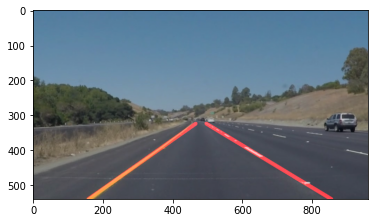

In [ ]:
#예시 이미지를 보여준다
#우측/좌측 차선에 맞추어 원본 이미지의 차선에 그려진 것을 확인할 수 있다.
annotated_image = annotate_image(mpimg.imread('/content/drive/MyDrive/Colab_Notebooks/road_lane_line_detection/test_images/solidYellowCurve.jpg'))
plt.imshow(annotated_image)

In [ ]:
test_images = os.listdir('/content/drive/MyDrive/Colab_Notebooks/road_lane_line_detection/test_images')

for image in test_images:
    annotated_image = annotate_image(mpimg.imread((os.path.join('/content/drive/MyDrive/Colab_Notebooks/road_lane_line_detection/test_images', image))))
    fname = image.split('.')[0] + '_annotated.jpg'  
    plt.imsave(os.path.join('/content/drive/MyDrive/Colab_Notebooks/road_lane_line_detection/test_images', fname), annotated_image)

#모든 test_images/*.jpg에 주석을 다는 작업이다.
#주석이 달린 영상을 test_images/<ori~> 로 저장한다.

비디오 테스트를 진행한다.

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#비디오 편집/저장/보기에 필요한 모둘과 함수를 불러온다

In [ ]:
def process_image(image):

    result = annotate_image(image)

    return result
#process_image함수는 image를 input으로 받아 annota_image함수에 넣어 반환한다.

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("/content/drive/MyDrive/Colab_Notebooks/road_lane_line_detection/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)
#최종적으로 동영상으로 표시한다. 
#차선 전체를 식별하고 비디오를 볼 수 있다.

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:09<00:00, 22.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.66 s, sys: 368 ms, total: 5.02 s
Wall time: 11.3 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('/content/drive/MyDrive/Colab_Notebooks/road_lane_line_detection/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:33<00:00, 20.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 14.9 s, sys: 1.06 s, total: 16 s
Wall time: 35.2 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))